In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix,f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import itertools as it
import time as time
import xgboost as xgb

In [123]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

In [124]:
data = pd.read_csv('../data/census-income.data', header=None)
data = data.replace('?', np.nan)
data = data.replace(' ?', np.nan)
data.columns=column_names
data.shape

(199523, 42)

In [125]:
missing_values = pd.DataFrame({'Count': data.isnull().sum()})
missing_values.sort_index(inplace=True)
missing_values

,Count
age,0
birth_dad,6713
birth_mom,6119
birth_self,3393
cap_gain,0
cap_loss,0
citizenship,0
class,0
dividend,0
education,0


In [126]:
data.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
data.dropna(inplace=True)
data.drop('inst_weight', axis=1, inplace=True)

In [127]:
train = data.copy()
train['income'] = train['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [128]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'lived_1yr', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

In [129]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
for pred in categorical_predictors:
    train[pred] = lbl.fit_transform(train[pred].astype(str))
    train[pred] = train[pred].astype(str)
# Convert the columns to 'str' data type

train.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,3,0,0,12,0,2,6,14,6,...,39,39,39,4,0,1,2,0,1,0
1,58,6,34,28,16,0,2,0,4,8,...,39,39,39,4,0,1,2,52,0,0


In [130]:
train.dtypes

age                 int64
class              object
ind_code_det       object
occ_code_det       object
education          object
wage_hr             int64
enroll_edu         object
marital            object
ind_code_maj       object
occ_code_maj       object
race               object
hisp_origin        object
sex                object
lab_union          object
reason_unemp       object
emp_status         object
cap_gain            int64
cap_loss            int64
dividend            int64
tax_filer_stat     object
prev_res_area      object
prev_res_state     object
fam_state          object
fam_state_sum      object
lived_1yr          object
num_ppl_worked      int64
fam_members_u18    object
birth_dad          object
birth_mom          object
birth_self         object
citizenship        object
employed_status    object
veteran_admin      object
veteran_benefit    object
weeks_worked        int64
year               object
income              int64
dtype: object

In [9]:
test = pd.read_csv('../census-income.test',header=None)
test.columns=column_names
test.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test.dropna(inplace=True)
test.drop('inst_weight', axis=1, inplace=True)

test['income'] = test['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)
for pred in categorical_predictors:
    test[pred] = le.fit_transform(test[pred])
test.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,38,4,6,36,3,0,2,2,10,5,...,26,26,26,0,0,1,2,12,1,0
1,44,6,37,12,8,0,2,2,2,10,...,40,40,40,4,0,1,2,26,1,0


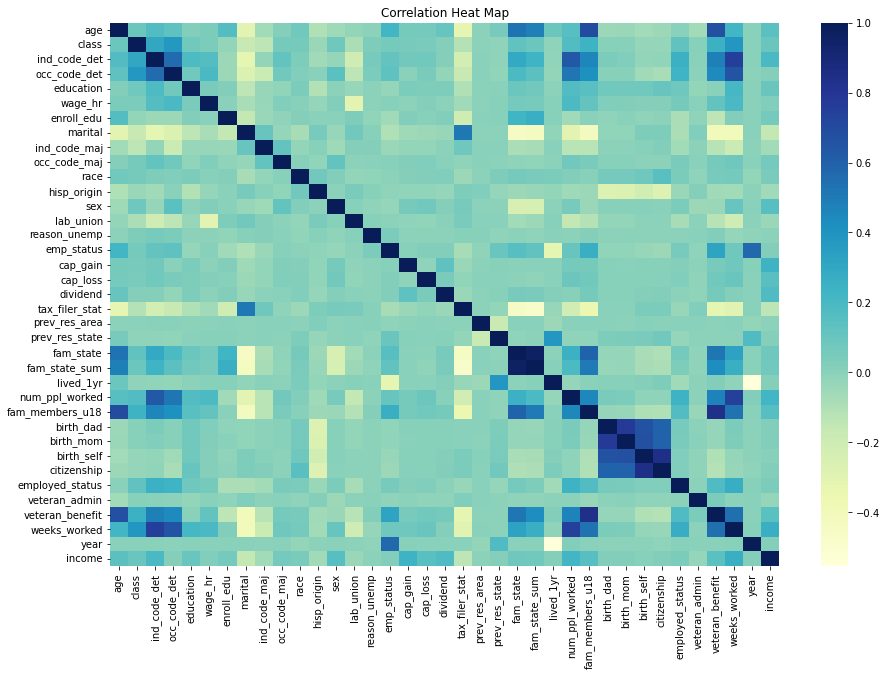

In [10]:
correlation_matrix = train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.title("Correlation Heat Map")
plt.show()

- accuracy + recall

In [11]:
X_train = train.drop(['income'],axis = 1)
y_train = train.income
X_test = test.drop(['income'],axis = 1)
y_test = test.income
X_train.shape

(190561, 36)

In [12]:
#sum(negative instances) / sum(positive instances)
(y_train.shape[0]-y_train.sum())/y_train.sum()

15.347344942952732

- The scale_pos_weight hyperparameter in XGBoost is used to address class imbalance in the training data. It controls the balance of positive and negative weights in the boosting process.
- If we increase the value of scale_pos_weight, the model will focus on classifying positives more correctly. This will increase the recall (true positive rate) since the focus is on identifying all positives. However, this will lead to identifying positives aggressively, and observations ‘similar’ to observations of the positive class will also be predicted as positive resulting in an increase in false positives and a decrease in precision. See the trend below as we increase the value of scale_pos_weight.
- For our case, this hyperparameter is set to 15

# Hyperparameter Visualizations

>5 0.952 (0.001)
>10 0.953 (0.001)
>50 0.958 (0.001)
>100 0.958 (0.001)
>500 0.957 (0.001)
>1000 0.956 (0.001)
>2000 0.954 (0.001)


Text(0.5, 0, 'Number of trees')

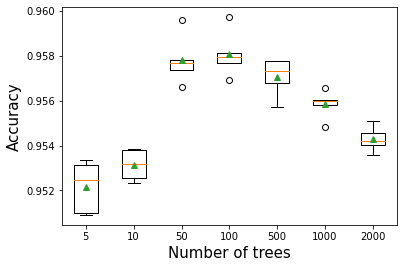

In [13]:
def get_models():
    models = dict()
    n_trees = [5, 10, 50, 100, 500, 1000, 2000]
    for n in n_trees:
        models[str(n)] = xgb.XGBClassifier(n_estimators=n)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Number of trees', fontsize=15)

>1 0.952 (0.002)
>2 0.955 (0.001)
>3 0.957 (0.001)
>4 0.958 (0.001)
>5 0.958 (0.002)
>6 0.958 (0.001)
>7 0.958 (0.001)
>8 0.958 (0.002)
>9 0.957 (0.001)
>10 0.957 (0.002)
>11 0.957 (0.001)
>12 0.957 (0.001)
>13 0.956 (0.001)
>14 0.956 (0.001)
>15 0.956 (0.001)
>16 0.956 (0.002)
>17 0.956 (0.001)
>18 0.956 (0.001)
>19 0.956 (0.001)
>20 0.955 (0.001)


Text(0.5, 0, 'Depth of each tree')

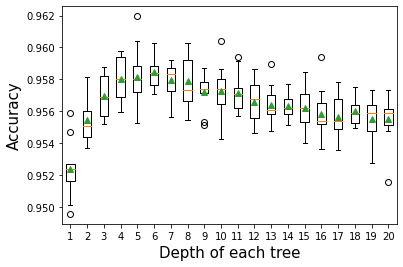

In [14]:
def get_models():
    models = dict()
    for i in range(1, 21):
        models[str(i)] = xgb.XGBClassifier(max_depth=i)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=10, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Depth of each tree', fontsize=15)

>0.0100 1.0 (0.0)
>0.0500 1.0 (0.0)
>0.1000 1.0 (0.0)
>0.2000 1.0 (0.0)
>0.3000 1.0 (0.0)
>0.4000 1.0 (0.0)
>0.5000 1.0 (0.0)
>0.6000 1.0 (0.0)
>0.8000 1.0 (0.0)
>1.0000 1.0 (0.0)


Text(0.5, 0, 'Learning rate')

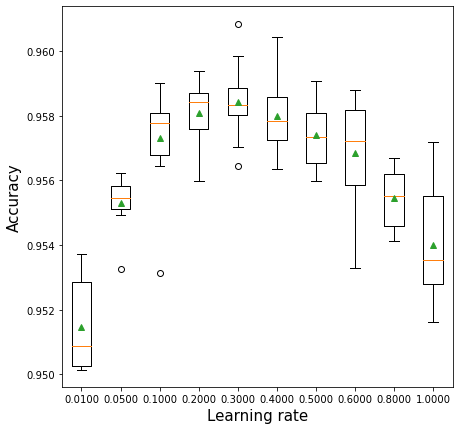

In [15]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(learning_rate=i)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=10, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Learning rate', fontsize=15)

>0.0000 1.0 (0.0)
>0.5000 1.0 (0.0)
>1.0000 1.0 (0.0)
>1.5000 1.0 (0.0)
>2.0000 1.0 (0.0)
>10.0000 1.0 (0.0)
>100.0000 1.0 (0.0)


Text(0.5, 0, 'reg_lambda')

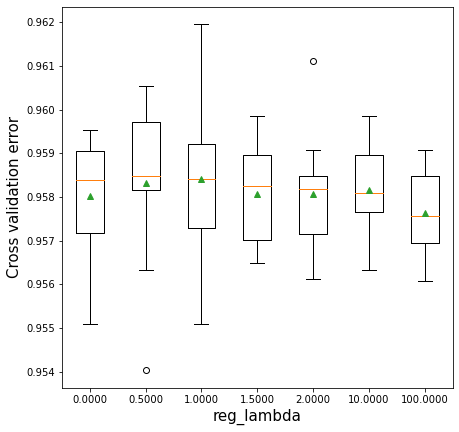

In [16]:
def get_models():
    models = dict()
    for i in [0, 0.5, 1.0, 1.5, 2, 10, 100]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(reg_lambda=i)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=10, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('reg_lambda', fontsize=15)

>0.0000 1.0 (0.0)
>10.0000 1.0 (0.0)
>100.0000 1.0 (0.0)
>1000.0000 0.9 (0.0)
>10000.0000 0.9 (0.0)
>100000.0000 0.9 (0.0)
>1000000.0000 0.9 (0.0)


Text(0.5, 0, 'gamma')

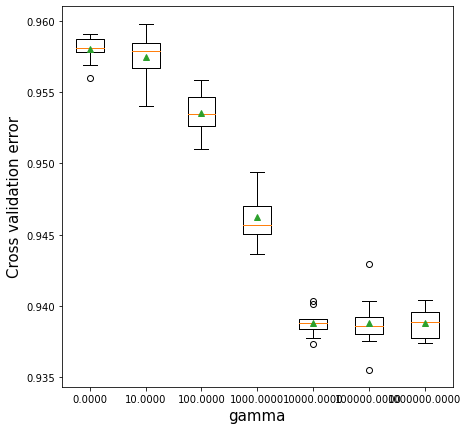

In [17]:
def get_models():
    models = dict()
    for i in [0, 10, 1e2, 1e3, 1e4, 1e5, 1e6]:
        key = '%.4f' % i
        models[key] = xgb.XGBClassifier(gamma=i)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=10, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error', fontsize=15)
plt.xlabel('gamma', fontsize=15)

# Model Development

In [198]:
def decision_threshold(model):
    threshold_hyperparam_vals = np.arange(0, 1.01, 0.01)

    predicted_class = cross_val_predict(model, X_train, y_train, cv=5)
    predicted_probability = model.predict_proba(X_train)

    results = []

    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = (predicted_probability[:,1] > threshold_prob).astype(int)
        accuracy = accuracy_score(y_true=y_train,y_pred=predicted_class)
        recall = recall_score(y_true=y_train,y_pred=predicted_class)
        results.append({'Threshold': threshold_prob, 'Accuracy': accuracy, 'Recall': recall})
    df_results=pd.DataFrame(results)
    return df_results

def model_performance(model_opt,opt_threshold):
    train_predictions = (model_opt.predict_proba(X_train)[:, 1] > opt_threshold).astype(int)
    test_predictions = (model_opt.predict_proba(X_test)[:, 1] > opt_threshold).astype(int)

    train_accuracy = accuracy_score(y_true=y_train, y_pred=train_predictions)
    train_recall = recall_score(y_true=y_train, y_pred=train_predictions)
    train_precision = precision_score(y_true=y_train, y_pred=train_predictions)
    test_accuracy = accuracy_score(y_true=y_test, y_pred=test_predictions)
    test_recall = recall_score(y_true=y_test, y_pred=test_predictions)
    test_precision = precision_score(y_true=y_test, y_pred=test_predictions)
    

    print("Training accuracy:", train_accuracy)
    print("Training recall:", train_recall)
    print("Training precision:", train_precision)
    print("Test accuracy:", test_accuracy)
    print("Test recall:", test_recall)
    print("Test precision:", test_precision)

In [133]:
#grid search of model1

start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.001,0.01],
              'reg_lambda': [1,10,100],
              'n_estimators': [100],
              'gamma': [1,10,100],
              'subsample': [1],
              'colsample_bytree':[1],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 1, 'scale_pos_weight': 15, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1}
Optimal cross validation score = 0.8416832439750376
Time taken = 2  minutes


In [134]:
model1 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 5, learning_rate = 0.1,n_estimators = 100,
                           reg_lambda = 0, gamma = 1, subsample = 1, colsample_bytree=1, scale_pos_weight=15).fit(X_train,y_train)
df1 = decision_threshold(model1)

In [135]:
filtered_df1 = df1[(df1['Accuracy'] >= 0.9) & (df1['Recall'] >= 0.85)]
filtered_df1.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
61,0.61,0.901381,0.861886
62,0.62,0.904083,0.855795
63,0.63,0.906607,0.850733


In [199]:
model_performance(model1,0.61)

Training accuracy: 0.9013806602610188
Training recall: 0.8618855623230677
Training precision: 0.3689680499449137
Test accuracy: 0.9212926765702372
Test recall: 0.7660847074038151
Test precision: 0.42525125628140703


In [137]:
start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01, 0.1],
              'reg_lambda': [0,1],
              'n_estimators': [500,700],
              'gamma': [0,1],
              'subsample': [0.3,0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 0, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.9354222570952818
Time taken = 7  minutes


In [138]:
model2 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.1,n_estimators = 700,
                           reg_lambda = 1, gamma = 1, subsample = 0.5,scale_pos_weight=15).fit(X_train,y_train)
df2 = decision_threshold(model2)

In [139]:
filtered_df2 = df2[(df2['Accuracy'] >= 0.95) & (df2['Recall'] >= 0.80)]
filtered_df2

,Threshold,Accuracy,Recall
42,0.42,0.950929,0.998027
43,0.43,0.952430,0.997855
44,0.44,0.953605,0.997684
45,0.45,0.954912,0.997512
46,0.46,0.956051,0.997083
47,0.47,0.957058,0.996998
48,0.48,0.958281,0.996912
49,0.49,0.959446,0.996654
50,0.50,0.960543,0.996140
51,0.51,0.961697,0.995711


In [200]:
model_performance(model2,0.42)

Training accuracy: 0.950929098818751
Training recall: 0.9980269366046153
Training precision: 0.5550042934834463
Test accuracy: 0.9479360878891763
Test recall: 0.6081474296799224
Test precision: 0.5759338640538886


In [148]:
model3 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 10, learning_rate = 0.01,n_estimators = 700,
                           reg_lambda = 1, gamma = 1, subsample = 0.3,scale_pos_weight=15).fit(X_train,y_train)
df3 = decision_threshold(model3)

In [149]:
filtered_df3 = df3[(df3['Accuracy'] >= 0.9) & (df3['Recall'] >= 0.85)]
filtered_df3.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
50,0.50,0.901412,0.926997
51,0.51,0.903432,0.922536
52,0.52,0.905736,0.917818
53,0.53,0.907883,0.913614
54,0.54,0.909908,0.909582
55,0.55,0.911923,0.905207
56,0.56,0.913592,0.900232
57,0.57,0.915528,0.896714
58,0.58,0.917423,0.892254
59,0.59,0.919286,0.888307


In [201]:
model_performance(model3,0.5)

Training accuracy: 0.9014121462418858
Training recall: 0.9269966543707644
Training precision: 0.3759654860482917
Test accuracy: 0.9080110663378842
Test recall: 0.8326867119301649
Test precision: 0.38749717896637326


In [151]:
#grid search of model 8x

start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01,0.1],
              'reg_lambda': [1,10],
              'n_estimators': [1000],
              'gamma': [1,10],
              'subsample': [0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.939079875097188
Time taken = 10  minutes


In [259]:
model8x = xgb.XGBClassifier(objective='binary:logistic',max_depth = 6, learning_rate = 0.03,n_estimators = 1000,
                           reg_lambda = 5, gamma = 5, subsample = 0.5, colsample_bytree=0.5, scale_pos_weight=15).fit(X_train,y_train)
df8x = decision_threshold(model8x)

In [261]:
filtered_df8x = df8x[(df8x['Accuracy'] >= 0.9) & (df8x['Recall'] >= 0.9)]
filtered_df8x.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
53,0.53,0.902399,0.926825
54,0.54,0.904844,0.923823
55,0.55,0.906996,0.919791
56,0.56,0.909021,0.915930
57,0.57,0.910832,0.911470
58,0.58,0.912941,0.907352
59,0.59,0.914893,0.903148


In [286]:
model_performance(model8x,0.41)

Training accuracy: 0.8711541186286805
Training recall: 0.9634554345028739
Training precision: 0.3176367441597375
Test accuracy: 0.9049938854473647
Test recall: 0.847397348852247
Test precision: 0.38051684088269455


<AxesSubplot:>

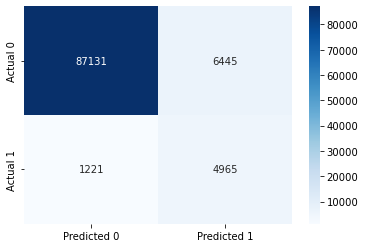

In [272]:
y_pred8x = model8x.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred8x), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
#the model is severely overfitting the training model. 
#The learning rate of 0.1 is too high, and gamma & reg_lambda too low

In [155]:
model8 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.01,n_estimators = 1000,
                           reg_lambda = 10, gamma = 10, subsample = 0.5, colsample_bytree=0.5, scale_pos_weight=15).fit(X_train,y_train)
df8 = decision_threshold(model8)

In [210]:
filtered_df8 = df8[(df8['Accuracy'] >= 0.9) & (df8['Recall'] >= 0.80)]
filtered_df8.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
56,0.56,0.900415,0.899631
57,0.57,0.902572,0.896028
58,0.58,0.904891,0.891053
59,0.59,0.907090,0.886077
60,0.60,0.909252,0.881959
61,0.61,0.911367,0.877584
62,0.62,0.913676,0.871837
63,0.63,0.915392,0.865660
64,0.64,0.917475,0.860599
65,0.65,0.919784,0.855966


In [278]:
model_performance(model8,0.53)

Training accuracy: 0.8862516464544161
Training recall: 0.9046066741013983
Training precision: 0.3389694300684689
Test accuracy: 0.9020568954110784
Test recall: 0.853055286129971
Test precision: 0.3732230002121791


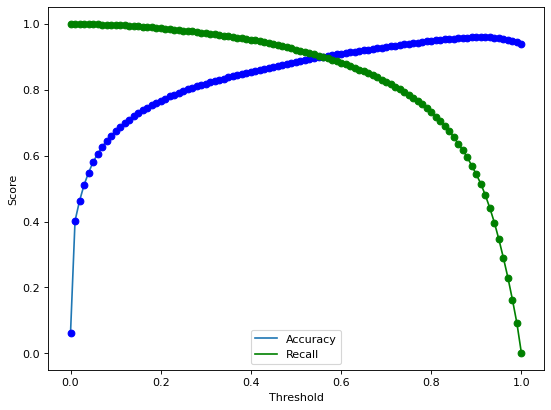

In [279]:
plt.figure(figsize=(8,6),dpi=80)
plt.plot(df8['Threshold'],df8['Accuracy'],label='Accuracy')
plt.plot(df8['Threshold'],df8['Accuracy'],'o',color='blue')
plt.plot(df8['Threshold'],df8['Recall'],label='Recall',color='green')
plt.plot(df8['Threshold'],df8['Recall'],'o',color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [280]:
importance = list(model8.feature_importances_)
name = list(model8.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
df.sort_values(by='Feature Importance', ascending=False).head(10)

,Feature Name,Feature Importance
34,weeks_worked,0.175682
12,sex,0.120443
25,num_ppl_worked,0.097985
26,fam_members_u18,0.075303
3,occ_code_det,0.050947
18,dividend,0.046812
0,age,0.042248
16,cap_gain,0.041592
22,fam_state,0.037562
9,occ_code_maj,0.029683



- An accuracy score of 91 means that the model correctly predicted 91% of all instances (both positive and negative) in the dataset.
- A recall score of 83 means that the model correctly identified 83% of the positive instances (true positives) out of all the actual positive instances in the dataset.

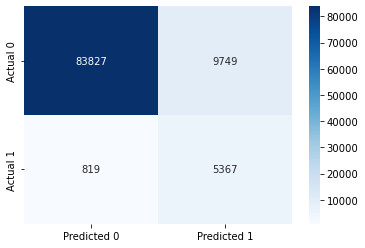

In [281]:
y_pred8 = model8.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred8), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [165]:
#grid search of model 10

start_time = time.time()
param_grid = {'max_depth': [6],
              'learning_rate': [0.01,0.05,0.1],
              'reg_lambda': [1,5,10],
              'n_estimators': [500,700,1000],
              'gamma': [1,5,10],
              'subsample': [0.7,1],
              'colsample_bytree':[0.7,1],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.7, 'scale_pos_weight': 15, 'reg_lambda': 5, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 1}
Optimal cross validation score = 0.9090055216806189
Time taken = 12  minutes


In [186]:
model10= xgb.XGBClassifier(objective='binary:logistic',max_depth = 6, learning_rate = 0.05,n_estimators = 1000,
                           reg_lambda = 5, gamma = 5, subsample = 0.7, colsample_bytree=0.7, scale_pos_weight=15).fit(X_train,y_train)
df10 = decision_threshold(model10)

In [187]:
filtered_df10 = df10[(df10['Accuracy'] >= 0.9) & (df10['Recall'] >= 0.85)]
filtered_df10.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
47,0.47,0.902168,0.967230
48,0.48,0.904398,0.965000
49,0.49,0.906718,0.962855
50,0.50,0.908885,0.960281
51,0.51,0.911000,0.957279
52,0.52,0.913004,0.954963
53,0.53,0.915067,0.952475
54,0.54,0.917003,0.949644
55,0.55,0.919128,0.946642
56,0.56,0.921075,0.942695


In [297]:
model_performance(model10,0.28)

Training accuracy: 0.8491349226756787
Training recall: 0.9909925366732435
Training precision: 0.2873917802766444
Test accuracy: 0.9030492572322126
Test recall: 0.8464274167474943
Test precision: 0.37512537612838515


In [188]:
#finer search of model 10

start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.05,0.1,0.15],
              'reg_lambda': [1,5,10],
              'n_estimators': [700,900,1100],
              'gamma': [1,5,10],
              'subsample': [0.5,0.7,1],
              'colsample_bytree':[0.5,0.7,1],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 5, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.15, 'gamma': 1, 'colsample_bytree': 0.7}
Optimal cross validation score = 0.9365085183957751
Time taken = 11  minutes


In [192]:
model11= xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.15,n_estimators = 700,
                           reg_lambda = 5, gamma = 1, subsample = 0.5, colsample_bytree=0.7, scale_pos_weight=15).fit(X_train,y_train)
df11 = decision_threshold(model11)

In [193]:
filtered_df11 = df11[(df11['Accuracy'] >= 0.9) & (df11['Recall'] >= 0.80)]
filtered_df11.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
16,0.16,0.902152,0.999914
17,0.17,0.905164,0.999914
18,0.18,0.908229,0.999828
19,0.19,0.911262,0.999828
20,0.20,0.914484,0.999743
...,...,...,...
86,0.86,0.985443,0.888479
87,0.87,0.985144,0.873123
88,0.88,0.984693,0.855366
89,0.89,0.984079,0.834434


In [214]:
#fit based on recall
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.05,0.1,0.15],
              'reg_lambda': [1,5,10],
              'n_estimators': [700,900,1100],
              'gamma': [1,5,10],
              'subsample': [0.5,0.7,1],
              'colsample_bytree':[0.5,0.7,1],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='recall',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.7, 'scale_pos_weight': 15, 'reg_lambda': 5, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}
Optimal cross validation score = 0.8770124468991081
Time taken = 9  minutes


In [215]:
model12= xgb.XGBClassifier(objective='binary:logistic',max_depth = 4, learning_rate = 0.05,n_estimators = 700,
                           reg_lambda = 5, gamma = 1, subsample = 0.7, colsample_bytree=0.7, scale_pos_weight=15).fit(X_train,y_train)
df12 = decision_threshold(model12)

In [218]:
filtered_df12 = df12[(df12['Accuracy'] >= 0.9) & (df12['Recall'] >= 0.85)]
filtered_df12.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
58,0.58,0.901171,0.885905
59,0.59,0.903558,0.881016
60,0.60,0.905915,0.876984
61,0.61,0.908124,0.872952
62,0.62,0.910438,0.867976
63,0.63,0.912479,0.860942
64,0.64,0.914652,0.855452


In [299]:
model_performance(model12,0.45)

Training accuracy: 0.8649618757248335
Training recall: 0.9332589860169855
Training precision: 0.30359435173299104
Test accuracy: 0.9073695395040196
Test recall: 0.8402845134173941
Test precision: 0.38643966991301765


In [229]:
#Gridsearch cv fit based on recall
start_time = time.time()
param_grid = {'max_depth': range(4,11,2),
              'learning_rate': [0.01,0.03,0.05,0.1],
              'reg_lambda': range(1,10,3),
              'n_estimators': range(500,1000,200),
              'gamma': range(1,10,3),
              'subsample': [0.3,0.6,0.9],
              'colsample_bytree':[0.3,0.6,0.9],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=5, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='recall',
                                    cv=cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameter values = {'subsample': 0.3, 'scale_pos_weight': 15, 'reg_lambda': 4, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 7, 'colsample_bytree': 0.6}
Optimal cross validation score = 0.9047378211066913
Time taken = 22  minutes


In [230]:
model13 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 4, learning_rate = 0.01,n_estimators = 500,
                           reg_lambda = 4, gamma = 7, subsample = 0.3, colsample_bytree=0.6, scale_pos_weight=15).fit(X_train,y_train)
df13 = decision_threshold(model13)

In [232]:
filtered_df13 = df13[(df13['Accuracy'] >= 0.9) & (df13['Recall'] >= 0.8)]
filtered_df13.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
64,0.64,0.900893,0.818564
65,0.65,0.904697,0.808441


In [233]:
model_performance(model13,0.64)

Training accuracy: 0.90089262755758
Training recall: 0.8185639529896199
Training precision: 0.36263443925056055
Test accuracy: 0.915538982779014
Test recall: 0.7678629162625283
Test precision: 0.4045996592844974


# Naive Model (without any tuning)

In [170]:
model_naive = xgb.XGBClassifier(objective='binary:logistic').fit(X_train,y_train)
df_naive = decision_threshold(model_naive)

In [176]:
filtered_df_naive = df_naive[(df_naive['Accuracy'] >= 0.9) & (df_naive['Recall'] >= 0.85)]
filtered_df_naive.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
8,0.08,0.901874,0.912242
9,0.09,0.909047,0.900232
10,0.10,0.915518,0.889508
11,0.11,0.921180,0.879043
12,0.12,0.925656,0.867805
13,0.13,0.930280,0.858712


In [172]:
model_performance(model_naive,0.08)

Training accuracy: 0.9018739406279355
Training recall: 0.9122415715878871
Test accuracy: 0.9187566408051162
Test recall: 0.7929194956353055


- Without scaling and the threshold being 0.08, the naive model is classifying most observations as 0s. 
- This is the reason why we want higher recall, because we prioritize greater opportunities for individuals to achieve wealth, even if some factors may be uncertain or doubtful.

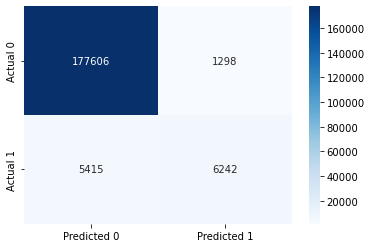

In [307]:
y_pred_naivetrain = model_naive.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred_naivetrain), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

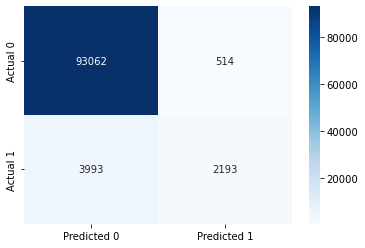

In [173]:
y_pred_naive = model_naive.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_naive), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [305]:
importance = list(model_naive.feature_importances_)
name = list(model_naive.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
df.sort_values(by='Feature Importance', ascending=False).head(10)

,Feature Name,Feature Importance
34,weeks_worked,0.215438
12,sex,0.108146
16,cap_gain,0.095704
3,occ_code_det,0.074314
18,dividend,0.051294
22,fam_state,0.046787
4,education,0.042944
0,age,0.034592
17,cap_loss,0.029553
25,num_ppl_worked,0.023237


# Final Model

In [300]:
model8 = xgb.XGBClassifier(objective='binary:logistic',max_depth = 8, learning_rate = 0.01,n_estimators = 1000,
                           reg_lambda = 10, gamma = 10, subsample = 0.5, colsample_bytree=0.5, scale_pos_weight=15).fit(X_train,y_train)
df8 = decision_threshold(model8)

In [301]:
filtered_df8 = df8[(df8['Accuracy'] >= 0.9) & (df8['Recall'] >= 0.80)]
filtered_df8.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
56,0.56,0.900415,0.899631
57,0.57,0.902572,0.896028
58,0.58,0.904891,0.891053
59,0.59,0.907090,0.886077
60,0.60,0.909252,0.881959
61,0.61,0.911367,0.877584
62,0.62,0.913676,0.871837
63,0.63,0.915392,0.865660
64,0.64,0.917475,0.860599
65,0.65,0.919784,0.855966


In [302]:
model_performance(model8,0.53)

Training accuracy: 0.8926433005704211
Training recall: 0.9111263618426696
Training precision: 0.35352661185633927
Test accuracy: 0.9065977025320262
Test recall: 0.8507921112188813
Test precision: 0.38534192414702007


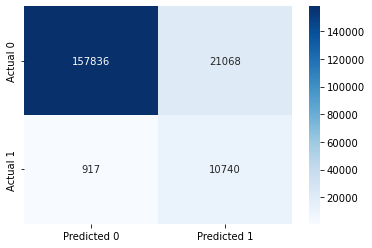

In [306]:
#training cm
y_pred8train = model8.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred8train), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

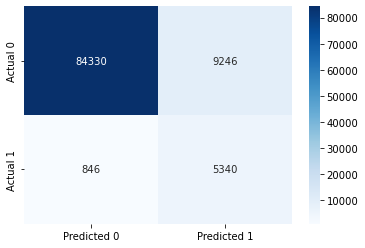

In [303]:
y_pred8 = model8.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred8), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [304]:
importance = list(model8.feature_importances_)
name = list(model8.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
df.sort_values(by='Feature Importance', ascending=False).head(10)

,Feature Name,Feature Importance
34,weeks_worked,0.161493
12,sex,0.115426
25,num_ppl_worked,0.089569
26,fam_members_u18,0.085098
3,occ_code_det,0.048995
18,dividend,0.046808
16,cap_gain,0.045381
0,age,0.038161
22,fam_state,0.036734
23,fam_state_sum,0.029409
